In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
file_name =  "/content/drive/My Drive/traffic sign recognition/dataset/GTSRB.zip"

with ZipFile(file_name, "r") as zip:
    zip.extractall()
    print("Done")

Done


In [ ]:
path = "/content/GTSRB/Training"
labelFile = "/content/drive/My Drive/traffic sign recognition/dataset/signnames.csv"
batch_size_val = 50
steps_per_epoch_val = 2000   #has to be equal to the length of the dataset divided by the batch size so cant define it now
epoch_val = 30
imageDimesions = (32, 32, 3)
testRatio = 0.2
validationRatio = 0.2

In [ ]:
import os
import cv2
import numpy as np

# Importing images
count = 0
images = []
classNo = []
myList = os.listdir(path)
noOfClasses = len(myList)
print("Total classes Detected: ", noOfClasses)
print("Importing classes....")

for x in range(0, noOfClasses):
    myPicList = os.listdir(path + "/" + str(myList[x]))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(myList[x]) + "/" + y)
        resImg = cv2.resize(curImg, (32, 32))
        images.append(resImg)
        classNo.append(count)
    print(count, end = " ")
    count += 1
print(" ")
images = np.array(images)
classNo = np.array(classNo)
print(images.shape)
print(images[1].shape)
print(classNo)


Total classes Detected:  43
Importing classes....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  
(26640, 32, 32, 3)
(32, 32, 3)
[ 0  0  0 ... 42 42 42]


In [ ]:
# Split my data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size = testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = validationRatio)


In [ ]:

# Check if number of images matches to number of labels for each data set
print("Data shapes")
print("train",end="");print(X_train.shape, y_train.shape)
print("validation",end="");print(X_validation.shape, y_validation.shape)
print("test",end="");print(X_test.shape, y_test.shape)
assert(X_train.shape[0] == y_train.shape[0])
assert(X_validation.shape[0] == y_validation.shape[0])
assert(X_test.shape[0] == y_test.shape[0])
assert(X_test.shape[1:] == imageDimesions)
assert(X_validation.shape[1:] == (imageDimesions))
assert(X_test.shape[1:] == (imageDimesions))



Data shapes
train(17049, 32, 32, 3) (17049,)
validation(4263, 32, 32, 3) (4263,)
test(5328, 32, 32, 3) (5328,)


In [ ]:
# Read CSV File
import pandas as pd
data = pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


In [ ]:
############################### DISPLAY SOME SAMPLES IMAGES  OF ALL THE CLASSES
import matplotlib.pyplot as plt
import random
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)- 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ "-"+row["SignName"])
            num_of_samples.append(len(x_selected))

[620, 632, 148, 347, 136, 617, 965, 194, 95, 104, 915, 92, 169, 120, 109, 806, 466, 562, 882, 166, 156, 104, 534, 176, 115, 963, 634, 538, 619, 893, 258, 198, 334, 854, 108, 307, 899, 222, 194, 265, 228, 124, 181]


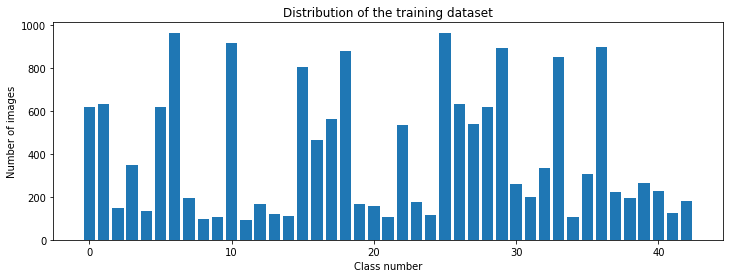

In [ ]:
############################### DISPLAY A BAR CHART SHOWING NO OF SAMPLES FOR EACH CATEGORY
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [ ]:
# Preprocessing images

def blurImage(img):
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    return img

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img


def preprocessing(img):
    img = blurImage(img) # No noise
    img = grayscale(img) # Convert to grayscale
    img = equalize(img)  # Standarize the lighting
    img = img/255        # Normalize values between 0-1
    return img

X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))



In [ ]:
# Add a depth of 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)


In [ ]:
# Augmentation of images: make it more generic
from keras.preprocessing.image import ImageDataGenerator

dataGen = ImageDataGenerator(width_shift_range = 0.1, # 0.1=10%
                             height_shift_range = 0.1,
                             zoom_range = 0.2, # 0.2 means that can go from 0.8 to 1.2
                             shear_range = 0.1, # magnitude of shear angle
                             rotation_range = 10) # deg
dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

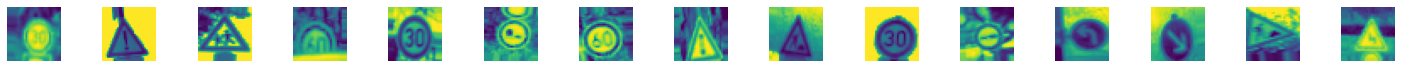

In [ ]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimesions[0],imageDimesions[1]))
    axs[i].axis('off')
plt.show()

In [ ]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

In [ ]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import  Conv2D, MaxPooling2D

def myModel():
    no_of_filters = 60
    size_of_filter = (5, 5) # this is the kernel that move around the image to get the featurs
    size_of_filter2 = (3, 3)
    size_of_pool = (2, 2) # scale down all feature map to generalize more, to reduce overfitting
    no_of_nodes = 500
    model = Sequential()
    model.add((Conv2D(no_of_filters, size_of_filter, input_shape = (imageDimesions[0], imageDimesions[1],1),activation = 'relu')))
    model.add((Conv2D(no_of_filters, size_of_filter, activation= "relu")))
    model.add(MaxPooling2D(pool_size= size_of_pool))

    model.add((Conv2D(no_of_filters // 2, size_of_filter2, activation= "relu")))
    model.add((Conv2D(no_of_filters // 2, size_of_filter2, activation= "relu")))
    model.add(MaxPooling2D(pool_size= size_of_pool))

    model.add(Flatten())
    model.add(Dense(no_of_nodes, activation= "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation= "softmax"))

    # COMPILE MODEL
    model.compile(Adam(lr=0.001),loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
X_train.shape[0]

17049

In [ ]:
# TRAIN MY MODEL

model =myModel()
print(model.summary())
history = model.fit_generator(dataGen.flow(X_train,y_train,batch_size=batch_size_val),                                                                                      
                                steps_per_epoch= X_train.shape[0] / batch_size_val,
                                epochs = epoch_val,
                                validation_data= (X_validation, y_validation),
                                validation_steps = X_train.shape[0] / batch_size_val,
                                verbose= 1,
                                shuffle=1
                              ) # borei kati na leipe

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten (Flatten)            (None, 480)               0

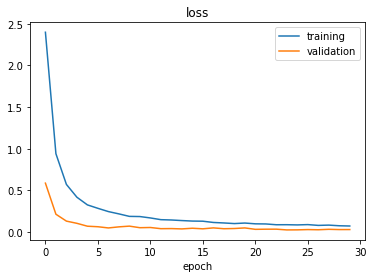

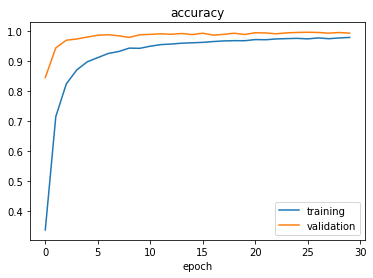

Test score: 0.015224102884531021
Test accuracy: 0.9958708882331848


In [ ]:
# PLOT
plt.figure(1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(['training', 'validation'])
plt.title('accuracy')
plt.xlabel('epoch')
plt.show()
score = model.evaluate(X_test, y_test, verbose=0)
print("Test score:", score[0])
print("Test accuracy:", score[1])



In [ ]:
# SAVE MY MODEL
model.save("/content/drive/My Drive/traffic sign recognition/traffic_sign_recognition.h5")
print("Done")

Done
